## VAE

There's a VAE inside SD. So, let's work with that.

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

In [2]:
from huggingface_hub import notebook_login
from pathlib import Path
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [18]:
import torch
from diffusers import AutoencoderKL
from PIL import Image
from torchvision import transforms

In [21]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device)

## Basic Encoder, Decoder for SD

In [78]:
def image_to_latents(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    im_tensor = transforms.ToTensor()(input_im).unsqueeze(0).to(torch_device)
    # change to -1 to 1 range
    im_tensor = im_tensor * 2 - 1
    with torch.no_grad():
        latent = vae.encode(im_tensor)
    
    # this is some specific to SD, but not related to VAE's at all
    return 0.18215 * latent.latent_dist.sample()

def latents_to_image(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

## Usage

In [60]:
# Download a demo Image
!curl --output ./images/macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0  26821      0  0:00:02  0:00:02 --:--:-- 26832


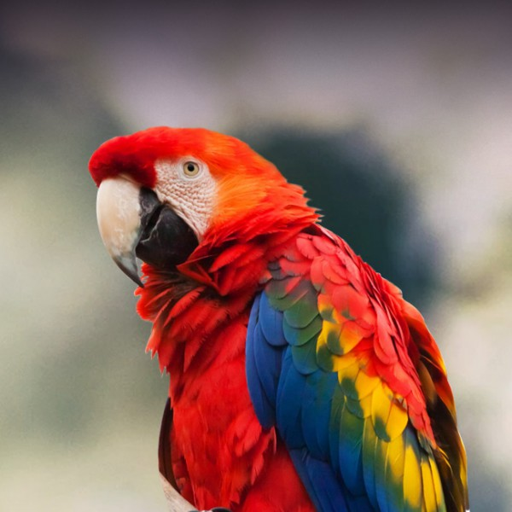

In [61]:
im_macaw = Image.open("./images/macaw.jpg").resize((512, 512))
im_macaw

In [79]:
latents = image_to_latents(im_macaw)
latents.shape

torch.Size([1, 4, 64, 64])

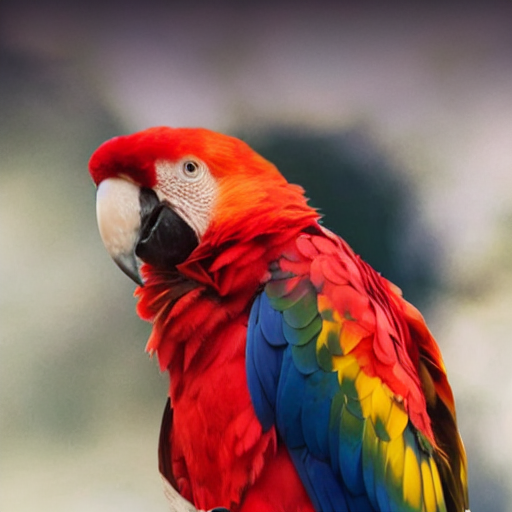

In [47]:
## Let's convert it back to an image
latents_to_image(latents)[0]

**See. It's the same thing.**

So, basically this is a very good compression system.

## What's inside in this Latents

In [49]:
from matplotlib import pyplot as plt

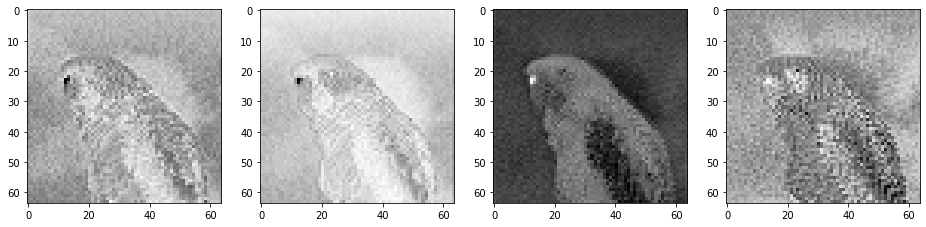

In [97]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    im_i = (latents[0][i]).cpu()
    axes[i].imshow(im_i, cmap="Greys")

Basically it has some data related to the image in these 4 dimensions.

## Let's try another example

In [100]:
def use_vae(image_path):
    im_source = Image.open(image_path).convert("RGB").resize((512, 512))
    latents = image_to_latents(im_source)
    im_converted = latents_to_image(latents)[0]
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes[0, 0].imshow(im_source)
    axes[0, 1].imshow(im_converted)
    axes[0, 2].imshow(latents[0][0].cpu(), cmap="Greys")
    axes[1, 0].imshow(latents[0][1].cpu(), cmap="Greys")
    axes[1, 1].imshow(latents[0][2].cpu(), cmap="Greys")
    axes[1, 2].imshow(latents[0][3].cpu(), cmap="Greys")
    return None


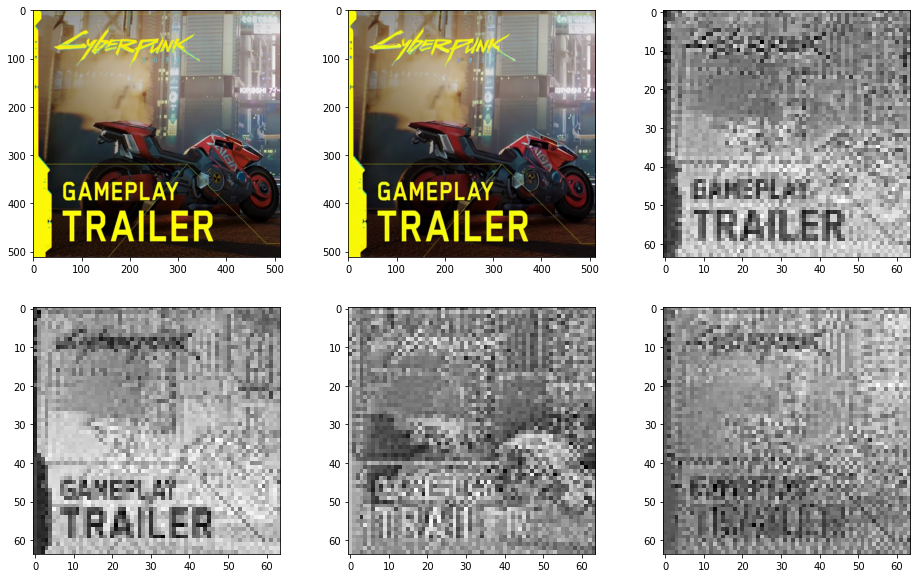

In [101]:
use_vae("./images/cyberfunk.png")

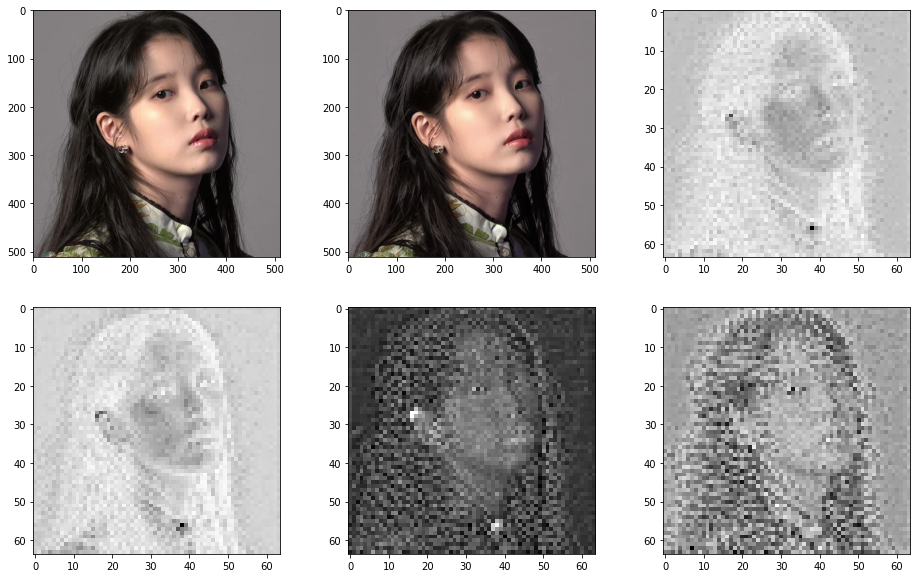

In [102]:
use_vae("./images/iu.png")